# Report: How to Analyze A/B Test Results?
Shabeel Kandi<br>
20-05-2020

## 1.Executive Summary

The AB test for Math Puzzle Game was run successfully according to design specifications.

From our anlysis of the metrics we can conclude the following:
* The treatment did not show any statistically significant change in conversion.
* The treatment did not show any statistically significant change in retention.
* The treatment has a negative effect on engagement by decreasing the average game rounds played per player. 
* The treatment increased the average revenue per daily active user, but this seems to be due to a novely effect, and infact fades over time. Both new players and old players has less engagement towards the treatment. While, old players are more likely to have a spend than new players under the treatment.

We observe a decrease in engagement and no significant change in conversions or retention under the treatment. Also since the increase in Average Revenue per daily active user is caused due to a novelty effect,  we can conclude that the we should not implement the treatment, as the treatment has negative impact on the user experience based on the metrics.
In this AB Test, we observed an interesting phenomena where the old players actaully ended up spending more due to the introduction of a new feature. We can infer from this observation that by periodically releasing new experiences that do not negatively impact engagement, we can increase in-game revenue.

## 2.Experiment Overview

**Experiment Name:** Math Puzzle Game experiment. <br>
It is conducted by Math Puzzle Game,with the overall business goal of improving user experience to make Math Puzzle Game a better game.
### 2.1 Game Overview <a class="anchor" id="current"></a>
* Math Puzzle Game is a mobile game. Like other Math Puzzle Game games, players need to beat levels to progress through a map". <br>
* At every level, players are faced with a math question they need to answer correctly to pass to the next level.
* The game is Free to Play meaning that players can download and play the game for free but can optionally buy hints on the levels. 

### 2.2 Description of Experiment <a class="anchor" id="description"></a>
* In 2017 we Math Puzzle Game ran an experiment (A/B Test) on the game, offering two different game experiences that we call A and B, group A being the control group where the experience is kept as is, and group B being the experiment group that is exposed to the new experience.
* We set the assignment process to randomly distribute players among the groups: 80% to group A (control) and 20% to group B (test).
*  The experiment ran from 2017-05-04 to 2017-05-22. 
 
### 2.3 Experiment Hypothesis <a class="anchor" id="hypothesis"></a>
The hypothesis was that the new change to the game would improve the user experience making Math Puzzle Game a better game.

### 2.4 Experiment Details <a class="anchor" id="details"></a>
The unit of diversion is a player_id. We assume that each player_id is independent. We assume α=0.05  (significance level ) 

## 3 Metric Choice <a class="anchor" id="metric"></a>
We use two types of metrics: Invariate and evaluation metrics.
* Invariate metrics are used for "sanity checks", to be confident in the validity of the test, as these metrics are not to be affected because of the experiment by making sure these metrics don't change drastically between control and experiment groups.
* Evaluation metrics are metrics used where a change is expected that are relevant to the business goal we aim to achieve. 

### 3.1 Invariate Metrics - Sanity Checks <a class="anchor" id="invariate"></a>

| Metric Name 	| Metric Formula 	|
|---------------------	|------------------------------------------------------------------------	|
| Player Distribution 	| ratio of count of players per group <br>to the total number of players 	|

### 3.2 Evaluation Metrics - Performance Indicators <a class="anchor" id="evaluation"></a>

| Metric Name 	| Metric Formula 	|
|-------------------	|----------------------------------------------------------	|
| Conversion 	| Conversion rate from no purchase to purchase, per group 	|
| Engagement 	| Average game rounds played per player 	|
| Average Revenue Per Daily Active User  	| Average purchases per player	|
| Retention  	| Ratio of number of active days to the total days per player	|

## 4 Analysis

### 4.0 Setup and Config

In [192]:
#Import libraries
from google.cloud import bigquery
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math as mt
import numpy as np
from numpy import sqrt, abs, round
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [193]:
# Initialisation
client = bigquery.Client()
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False

def query_bq(query):
    df = client.query(query).to_dataframe()
    return df

### 4.1 Missing Values Check

#### Nulls check in assignment table

In [194]:
sql = """
SELECT col_name, COUNT(1) nulls_count
FROM `abtest.assignment` t,
UNNEST(REGEXP_EXTRACT_ALL(TO_JSON_STRING(t), r'"(\w+)":null')) col_name
GROUP BY col_name 
"""
df = query_bq(sql)
df

,col_name,nulls_count
0,conversion_date,10045133


#### Nulls check in activity table

In [195]:
sql = """
SELECT col_name, COUNT(1) nulls_count
FROM `abtest.activity` t,
UNNEST(REGEXP_EXTRACT_ALL(TO_JSON_STRING(t), r'"(\w+)":null')) col_name
GROUP BY col_name 
"""
df = query_bq(sql)
df

,col_name,nulls_count


Looks like we have no missing values unless where expected.

### 4.2 Sanity Checks

#### Player Distribution by Group

In [196]:
sql = """
select abtest_group,count(playerid) as playerid_count ,
count(playerid)/(select  count(playerid) from `abtest.assignment` ) as player_distribution
from `abtest.assignment` 
group by abtest_group 
"""
df = query_bq(sql)

In [197]:
df

,abtest_group,playerid_count,player_distribution
0,A,8265610,0.800074
1,B,2065446,0.199926


This looks similar to the original design of 80-20 split.To make sure difference in player distribution is not significant and is random and even like we expected. We can model this diversion in the following way:<br>
We expect the number of players in the control group to be about a 20% of the total number of players. <br>
From central limit theorem we approximate the binomial distribution to a normal distribution (when n is large enough) with a mean of $p$ and a standard deviation $\sqrt{\frac{p(1-p)}{N}}$
<center> <font size="4"> $ X$~$N( p,\sqrt{\frac{p(1-p)}{N}})$ </font></center>
What we want to test is whether our observed $\hat{p}$ (number of samples in control divided by total number of damples in both groups) is not significantly different than $p=0.2$. In order to do that we can calculate the margin of error acceptable at a 95% confidence level:
<center> <font size="4"> $ ME=Z_{1-\frac{\alpha}{2}}SD$ </font></center>
confidence interval is derived to tell us in which range an observed $p$ can exist and be acceptable as "the same" as the expected value.
<center> <font size="4"> $ CI=[\hat{p}-ME,\hat{p}+ME]$ </font></center>
When our obsereved $\hat{p}$ is within this range,the test was passed.

In [198]:
def get_z_score(alpha):
    return norm.ppf(alpha)

p=0.2
alpha=0.05
p_hat=df.loc[df.abtest_group=='B','player_distribution'].values[0]
total_count=df.playerid_count.sum()
stdev=mt.sqrt(p*(1-p)/(total_count))
margin_error=round(get_z_score(1-(alpha/2))*stdev,4)
print ("The confidence interval for player_distribution for group B is between",p-margin_error,"and",p+margin_error)
print(p_hat,"is inside this range")

The confidence interval for player_distribution for group B is between 0.1998 and 0.20020000000000002
0.19992593206347928 is inside this range


Our observed $\hat{p}$  is inside this range which means the player_distribution follows the original design requirement. This invariant metric sanity test is passed.

In [199]:
# Number of players in group A and group B by assignment date
sql = """
with a as (
select abtest_group,a.assignment_date,count(playerid) as playerid_count
from `abtest.assignment` a
group by  assignment_date,abtest_group)
,
b as 
(select assignment_date,count(playerid) as playerid_count_per_assignment_date 
from `abtest.assignment` 
group by  assignment_date
) 
select a.*,b.playerid_count_per_assignment_date,
a.playerid_count/b.playerid_count_per_assignment_date as percent_assigned_per_assignment_date from a
left join b
on a.assignment_date = b.assignment_date
order by assignment_date,abtest_group
"""
df = query_bq(sql)

Text(0.5, 1.0, 'Number of Players by Groups and Assignment Date')

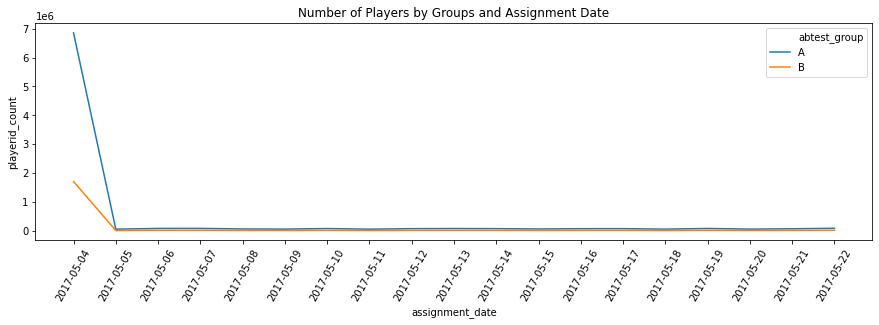

In [200]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
ax = sns.lineplot(x="assignment_date", y="playerid_count", hue="abtest_group", data=df)
plt.xticks(rotation=60)
ax.set_title('Number of Players by Groups and Assignment Date')

Text(0.5, 1.0, 'Player Distribution into Groups A and B, By Day')

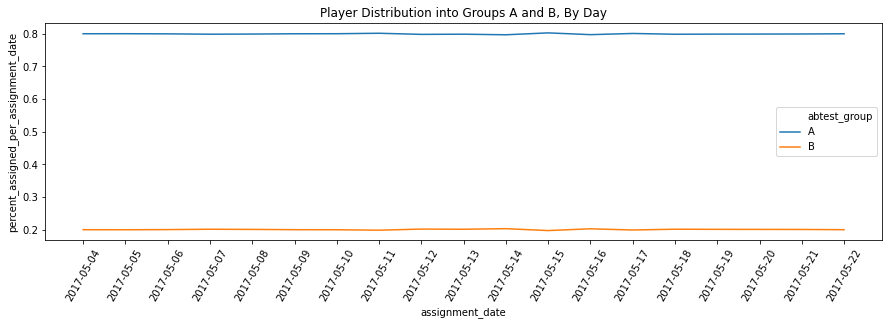

In [201]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
ax = sns.lineplot(x="assignment_date", y="percent_assigned_per_assignment_date", hue="abtest_group", data=df)
plt.xticks(rotation=60)
ax.set_title('Player Distribution into Groups A and B, By Day')

From the above charts we see that most of the players were assigned on the first assignment day, and then the remaining were added subsequently on each assignment day. But the player distribution follows the 80-20 split into groups A and B based on the above chart. This is consistent with our experiment design, thus concluding our sanity checks

### 4.3 Effect on evaluation metrics
For each evaluation metric, the difference between the values from both groups is measured. Then, we compute the confidence interval for that difference and test whether or not this confidence interval is both statistically significant.

#### 4.3.1 Conversion 
Conversion rate tells us the rate at which players convert to paying members. We look at its confidence intervals comparision and cumulative conversion rates. Be careful that some of the players have converted before their assignment date.

In [202]:
sql_conversion = """
SELECT 
    abtest_group,
    count(playerid) as abtest_entrants,
    count(
        case
        when conversion_date is not null 
        and cast(conversion_date as date) >= cast(assignment_date as date) then 1 else null 
        end) 
        as abtest_conversions
FROM `abtest.assignment`
GROUP BY abtest_group
"""
conversion_df = query_bq(sql_conversion)

In [203]:
conversion_df['conversion_rate']=conversion_df.abtest_conversions/conversion_df.abtest_entrants
conversion_df

,abtest_group,abtest_entrants,abtest_conversions,conversion_rate
0,A,8265610,32835,0.003972
1,B,2065446,8372,0.004053


From above stats we can see that the control group and experiment group amount of entrants are about 80% and 20%, respectively.
The overall conversion rate of the B group is slightly better than A group (3% relative increase). To check weather this increase is statistically significant we will calculate the confidence intervals of the difference of the conversion rate for the two groups and test whether or not this confidence interval is statistically significant. 


We can make the null hypothesis as: there is no differece of the conversion rate between A and B. The test statistic we use is difference between conversion rates of the 2 groups. A ztest will be conducted to calculate the p-value. Let's check the statistic significance.

Hypothesis:
* H0: conversion rate is no difference between control group and test group
* H1: conversion rate in treatment group is different than that in control group

In [204]:
abtest_conversions_A=conversion_df.loc[conversion_df.abtest_group=='A','abtest_conversions'].values[0]
abtest_conversions_B=conversion_df.loc[conversion_df.abtest_group=='B','abtest_conversions'].values[0]


abtest_entrants_A=conversion_df.loc[conversion_df.abtest_group=='A','abtest_entrants'].values[0]
abtest_entrants_B=conversion_df.loc[conversion_df.abtest_group=='B','abtest_entrants'].values[0]

conv_rate_A=conversion_df.loc[conversion_df.abtest_group=='A','conversion_rate'].values[0]
conv_rate_B=conversion_df.loc[conversion_df.abtest_group=='B','conversion_rate'].values[0]

conv_rate_pooled=(abtest_conversions_A+abtest_conversions_B)/(abtest_entrants_A+abtest_entrants_B)
conv_rate_stdev_pooled=mt.sqrt(conv_rate_pooled*(1-conv_rate_pooled)*(1/abtest_entrants_A+1/abtest_entrants_B))

alpha=0.05
conv_rate_ME=round(get_z_score(1-alpha/2)*conv_rate_stdev_pooled,4)
conv_rate_diff=round(conv_rate_B-conv_rate_A,4)

z = ((conv_rate_B-conv_rate_A) - 0)/conv_rate_stdev_pooled
pval = round(2*(1 - norm.cdf(abs(z))),4)
print("p-value is",pval)
print("The change due to the experiment is",conv_rate_diff*100,"%")
print("Confidence Interval of difference: [",conv_rate_diff-conv_rate_ME,",",conv_rate_diff+conv_rate_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0.")

p-value is 0.099
The change due to the experiment is 0.01 %
Confidence Interval of difference: [ 0.0 , 0.0002 ]
The change is statistically significant if the CI doesn't include 0.


Our significance level of 0.05. Based on the above p-value test we cannot reject the null hypothesis. Based on the confidence interval of the difference, we again observe that the conversion rate is not significantly different between the two

##### We can take a look at the conversion rates over time to see what is happening.


In [205]:
sql_conversion_over_time = """
SELECT 
    abtest_group,assignment_date,
    count(playerid) as abtest_entrants,
    count(
        case
        when conversion_date is not null 
        and cast(conversion_date as date) >= cast(assignment_date as date) then 1 else null 
        end) 
        as abtest_conversions
FROM `abtest.assignment`
GROUP BY abtest_group,assignment_date
"""
df_conversion_over_time = query_bq(sql_conversion_over_time)
df_conversion_over_time['conversion_rate']=df_conversion_over_time.abtest_conversions/df_conversion_over_time.abtest_entrants

Text(0.5, 1.0, 'Conversion Rates Over Time')

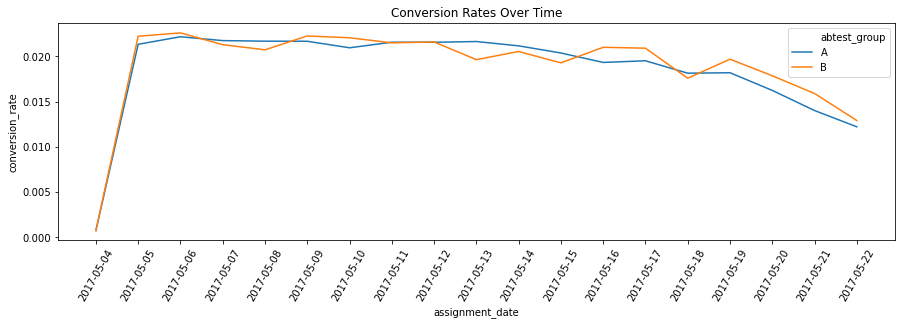

In [206]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
plt.xticks(rotation=60)
ax = sns.lineplot(x="assignment_date", y="conversion_rate", hue="abtest_group", data=df_conversion_over_time)
ax.set_title('Conversion Rates Over Time')

We can see that the conversion rate is not actually different over the time during the time period of our experiment. This confirms our results.

#### 4.3.2 Retention 
Retention is calculated as the ratio of number of active days to the total days per player. This gives us a good measure of user activity.


In [223]:
sql = """
with table1 as 
(SELECT playerid,count(distinct activity_date) as num_days_active,
19 as total_num_days,
count(distinct activity_date)/19 as retention
FROM abtest.activity 
where cast(activity_date as date)>=(select min(cast(assignment_date as date)) from abtest.assignment)
and  cast(activity_date as date)<=(select max(cast(assignment_date as date)) from abtest.assignment)
group by playerid
),
table2 as (
select b.*, abtest_group from 
`abtest.assignment` a
inner join table1 b
on a.playerid =b.playerid )
select abtest_group,count(playerid) as num_players,avg(num_days_active) as avg_num_days_active, max(total_num_days) as total_num_days,
avg(retention) as avg_retention,stddev(retention) as stdev
from table2
group by abtest_group
"""
retention =query_bq(sql)
retention

,abtest_group,num_players,avg_num_days_active,total_num_days,avg_retention,stdev
0,A,8265610,12.028104,19,0.633058,0.252350
1,B,2065446,12.023382,19,0.632810,0.252571


We can make the null hypothesis as: there is no differece of the retention rates between A and B. The test statistic we use is difference between retention rates of the 2 groups. A ztest will be conducted to calculate the p-value. Let's check the statistic significance.

Hypothesis:
* H0: retention rate is no difference between control group and test group
* H1: retention rate in treatment group is different than that in control group

In [226]:
X1= retention.loc[retention.abtest_group=='A','avg_retention'].values[0]
X2= retention.loc[retention.abtest_group=='B','avg_retention'].values[0]
mudiff=0
sd1=retention.loc[retention.abtest_group=='A','stdev'].values[0]
sd2=retention.loc[retention.abtest_group=='B','stdev'].values[0]
n1=retention.loc[retention.abtest_group=='A','num_players'].values[0]
n2=retention.loc[retention.abtest_group=='B','num_players'].values[0]
pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
z = ((X1 - X2) - mudiff)/pooledSE
pval = 2*(1 - norm.cdf(abs(z)))
alpha=0.05
ME=round(get_z_score(1-alpha/2)*pooledSE,4)
diff=round(X2-X1,4)
print("p-value is",pval)
print("The change due to the experiment in engagement is",diff*100,"%")
print("Confidence Interval of difference: [",diff-ME,",",diff+ME,"]")
print ("The change is statistically significant if the CI doesn't include 0.")

p-value is 0.20587705835186143
The change due to the experiment in engagement is -0.02 %
Confidence Interval of difference: [ -0.0006000000000000001 , 0.0002 ]
The change is statistically significant if the CI doesn't include 0.


We do not reject the null hypothesis.The difference in retention is not significant

#### 4.3.3 Engagement 
The engagement of the playeres are very important to determining the improvement in user experience of the game. We calculate engagement as the Average game rounds played per player 

In [207]:
sql_engagement="""
with joined as (

select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when purchases >0 then 1 else 0 end as purchasesFlag
,case when conversion_date is not null and cast(conversion_date as date)>=cast(activity_date as date) then 1 else 0 end as conversionFlag

from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
table2 as (
select avg(gameends) as gameends_per_day,playerid,abtest_group
from joined
group by playerid,abtest_group)

select abtest_group,avg(gameends_per_day) avg_gameends_per_player_per_day,count(playerid) as num_players,stddev(gameends_per_day) as stddev
from table2
group by abtest_group

"""
engagement =query_bq(sql_engagement)

In [208]:
engagement

,abtest_group,avg_gameends_per_player_per_day,num_players,stddev
0,A,13.182673,8265610,9.688396
1,B,12.948998,2065446,9.505924


We can see a clear difference in the engagement between the two groups. However we must verify if this difference is statistically significant. Since engagement is a bit more comlpicated metric, we see its distibution first.

Text(0.5, 1.0, 'Distribution of gameends per player per day')

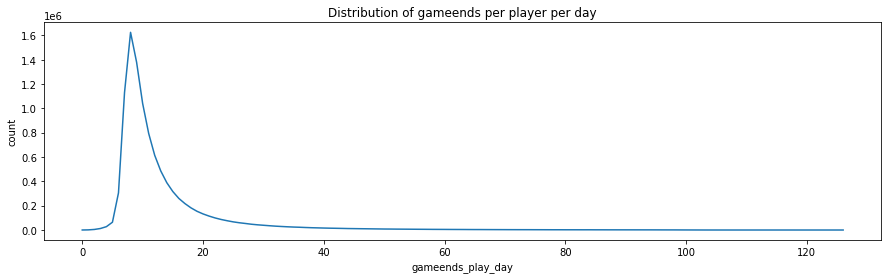

In [209]:
sql_engagement_dist="""
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when purchases >0 then 1 else 0 end as purchasesFlag
,case when conversion_date is not null and cast(conversion_date as date)>=cast(activity_date as date) then 1 else 0 end as conversionFlag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
table2 as (
select avg(gameends) as gameends_per_day,playerid,abtest_group
from joined
group by playerid,abtest_group)
select count(playerid) as count,ROUND(gameends_per_day, 0) as gameends_play_day
from table2
 group by  ROUND(gameends_per_day, 0)
"""
engagement_dist =query_bq(sql_engagement_dist)
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
ax = sns.lineplot(x="gameends_play_day", y="count", data=engagement_dist)
ax.set_title('Distribution of gameends per player per day')

The distributions of gameends per player per day have right skewed distribution with a long tail. However we can use the z-test, since we will be comparing the means of gameends per player per day for each of the two group, and since the the sample is large enough, by Central Limit Theorem, we can assume normal distribution of the means.

We can make the null hypothesis as: there is no differece of the engagement between A and B. The test statistic we use is difference between engagements of the 2 groups. A permutation test will be conducted to calculate the p-value. Let's check the statistic significance.

Hypothesis:
* H0: Engagement is not differet between control group and test group
* H1: Engagement in treatment group different than that in control group

In [210]:
X1= engagement.loc[engagement.abtest_group=='A','avg_gameends_per_player_per_day'].values[0]
X2= engagement.loc[engagement.abtest_group=='B','avg_gameends_per_player_per_day'].values[0]
mudiff=0
sd1=engagement.loc[engagement.abtest_group=='A','stddev'].values[0]
sd2=engagement.loc[engagement.abtest_group=='B','stddev'].values[0]
n1=engagement.loc[engagement.abtest_group=='A','num_players'].values[0]
n2=engagement.loc[engagement.abtest_group=='B','num_players'].values[0]
pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
z = ((X1 - X2) - mudiff)/pooledSE
pval = 2*(1 - norm.cdf(abs(z)))
alpha=0.05
engagement_ME=round(get_z_score(1-alpha/2)*pooledSE,4)
engagement_diff=round(X2-X1,4)
print("p-value is",pval)
print("The change due to the experiment in engagement is",engagement_diff*100,"%")
print("Confidence Interval of difference: [",engagement_diff-engagement_ME,",",engagement_diff+engagement_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0.")

p-value is 0.0
The change due to the experiment in engagement is -23.369999999999997 %
Confidence Interval of difference: [ -0.2482 , -0.21919999999999998 ]
The change is statistically significant if the CI doesn't include 0.


Based on the above results,we reject the null hypothesis, and the avg_gameends_per_player_per_day is different. We can say confidently that the engagement has decreased by 23.36% in the treatment group and this change was significant.
##### Let us take a look at the engagement over time to see whats happening

Text(0.5, 1.0, 'Engagenment Over Time')

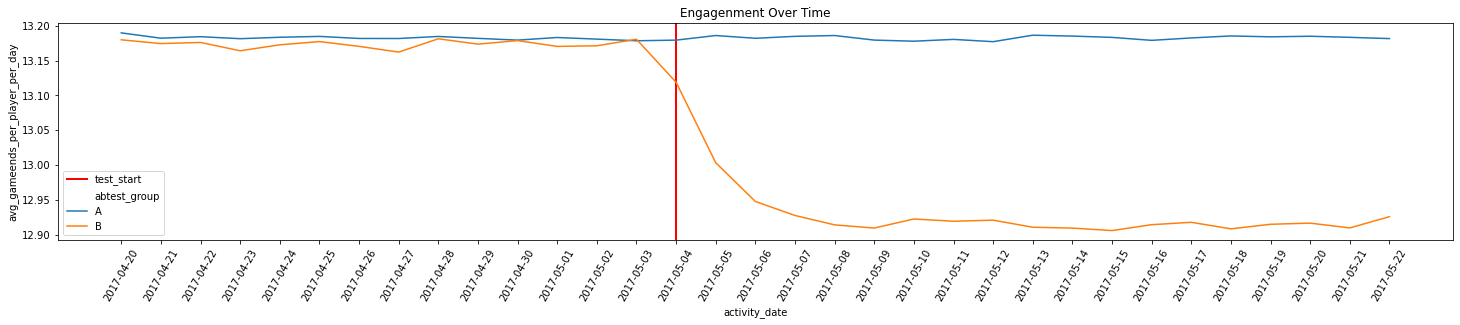

In [211]:
sql_eng_plot = """
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
historical as
(
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when purchases >0 then 1 else 0 end as purchasesFlag
,case when conversion_date is not null and cast(conversion_date as date)>=cast(activity_date as date) then 1 else 0 end as conversionFlag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)<cast(assignment_date as date)
)
(select  abtest_group,activity_date, avg(gameends) as avg_gameends_per_player_per_day
from joined group by abtest_group,activity_date)
union all
(select  abtest_group,activity_date, avg(gameends) as avg_gameends_per_player_per_day
from historical group by abtest_group,activity_date)
"""
eng_plot =query_bq(sql_eng_plot)
fig, ax = plt.subplots()
fig.set_size_inches(25, 4)
plt.xticks(rotation=60)
ax.axvline(x=14 , color='red', linewidth=2, label='test_start')
ax = sns.lineplot(x="activity_date", y="avg_gameends_per_player_per_day", hue="abtest_group", data=eng_plot)
ax.set_title('Engagenment Over Time')

We can see that after the experiment starts on 2017-05-04 , group B has been dropping in avg game rounds per player since the experiment starts, while the control group has stayed stable, which is a indication of the treatment has lowered the engagement.

#### 4.3.4 Average Revenue Per Daily Active User (ARPDAU)
The Average Revenue Per Daily Active User of the players is an important metric in determining the commercial success of the game. We calculate engagement as the Average purchases per player 

In [212]:
sql_arpdau="""
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when purchases >0 then 1 else 0 end as purchasesFlag
,case when conversion_date is not null and cast(conversion_date as date)>=cast(activity_date as date) then 1 else 0 end as conversionFlag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
table2 as (
select avg(purchases) as avg_purchases,playerid,abtest_group
from joined
group by playerid,abtest_group)
select abtest_group,avg(avg_purchases) arpdau,count(playerid) as num_players,stddev(avg_purchases) as stddev
from table2
group by abtest_group
"""
arpdau_df =query_bq(sql_arpdau)

In [213]:
arpdau_df

,abtest_group,arpdau,num_players,stddev
0,A,0.030647,8265610,0.736389
1,B,0.032558,2065446,0.753496


We can see a difference in the average revenue per daily active user between the two groups. However we must verify if this difference is statistically significant. We see its distibution first.

Text(0.5, 1.0, 'Distribution of ARPDAU')

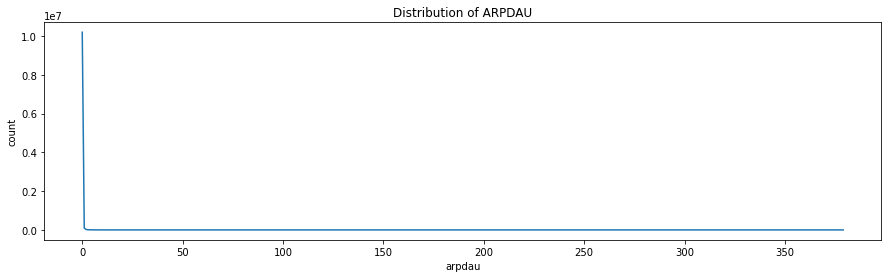

In [214]:
sql_arpdau_dist="""
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when purchases >0 then 1 else 0 end as purchasesFlag
,case when conversion_date is not null and cast(conversion_date as date)>=cast(activity_date as date) then 1 else 0 end as conversionFlag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
table2 as (
select avg(purchases) as avg_purchases,playerid,abtest_group
from joined
group by playerid,abtest_group)
select count(playerid) as count,ROUND(avg_purchases, 0) as arpdau
from table2
 group by  ROUND(avg_purchases, 0)
"""
arpdau_dist =query_bq(sql_arpdau_dist)
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
ax = sns.lineplot(x="arpdau", y="count", data=arpdau_dist)
ax.set_title('Distribution of ARPDAU')

The distribution has right skewed distribution with a long tail, where the average purchase has a vast majority of people with 0 purchase, indicating a very small percentage of people making a relatively large impact.

In [215]:
X1= arpdau_df.loc[arpdau_df.abtest_group=='A','arpdau'].values[0]
X2= arpdau_df.loc[arpdau_df.abtest_group=='B','arpdau'].values[0]
mudiff=0
sd1=arpdau_df.loc[arpdau_df.abtest_group=='A','stddev'].values[0]
sd2=arpdau_df.loc[arpdau_df.abtest_group=='B','stddev'].values[0]
n1=arpdau_df.loc[arpdau_df.abtest_group=='A','num_players'].values[0]
n2=arpdau_df.loc[arpdau_df.abtest_group=='B','num_players'].values[0]
pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
z = ((X1 - X2) - mudiff)/pooledSE
pval = 2*(1 - norm.cdf(abs(z)))
alpha=0.05
ME=round(get_z_score(1-alpha/2)*pooledSE,4)
diff=round(X2-X1,4)
print("p-value is",pval)
print("The change due to the experiment in Average Revenue Per Daily Active User is",diff*100,"%")
print("Confidence Interval of difference: [",round(diff-ME,4),",",round(diff+ME,4),"]")
print ("The change is statistically significant if the CI doesn't include 0.")

p-value is 0.0010570033258021638
The change due to the experiment in Average Revenue Per Daily Active User is 0.19 %
Confidence Interval of difference: [ 0.0008 , 0.003 ]
The change is statistically significant if the CI doesn't include 0.


We reject the null hypothesis. Thus the increase in Average Revenue Per Daily Active User of 0.19% is significant, where alpha is 0.05.

##### Let us take a look at the engagement over time to see whats happening

Text(0.5, 1.0, 'Average Revenue Per Daily Active User Over Time')

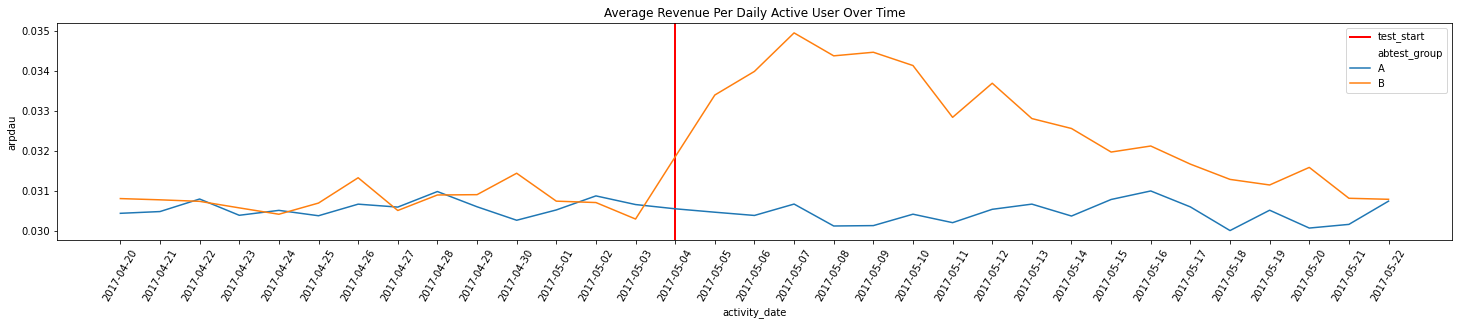

In [216]:
sql_arpdau_plot = """
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
historical as
(
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when purchases >0 then 1 else 0 end as purchasesFlag
,case when conversion_date is not null and cast(conversion_date as date)>=cast(activity_date as date) then 1 else 0 end as conversionFlag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)<cast(assignment_date as date)
)
(select  abtest_group,activity_date, avg(purchases) as arpdau
from joined group by abtest_group,activity_date)
union all
(select  abtest_group,activity_date, avg(purchases) as arpdau
from historical group by abtest_group,activity_date)
"""
arpdau_plot =query_bq(sql_arpdau_plot)
fig, ax = plt.subplots()
fig.set_size_inches(25, 4)
plt.xticks(rotation=60)
ax.axvline(x=14 , color='red', linewidth=2, label='test_start')
ax = sns.lineplot(x="activity_date", y="arpdau", hue="abtest_group", data=arpdau_plot)
ax.set_title('Average Revenue Per Daily Active User Over Time')

We initially see an increase in Average Revenue per Daily Active user in the treatment group, but this seems to be fading as we move towards the later days. To understand what could be happening we can try and understand how different users are behaving to the treatment.

### 4.4 Do different types of players react differently to the treatment? 


Novelty effect is a common issue during AB test. The most common way to check for novelty effect is by segmenting players in new vs old. New players are defined when assginment date and install date are same.

In [217]:
# Accounting For Novelty
sql="""
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when assignment_date=install_date then 1 else 0 end as new_player_flag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date) 
),
table2 as (
select avg(purchases) as avg_purchases,playerid,abtest_group,avg(gameends) as gameends_per_day,new_player_flag
from joined
group by playerid,abtest_group,new_player_flag)
select abtest_group,avg(avg_purchases) arpdau,avg(gameends_per_day) as avg_gameends_per_player_day,count(playerid) as num_players,new_player_flag,
stddev(gameends_per_day) as stddev_engagement,stddev(avg_purchases) as stddev_arpdau
from table2
group by abtest_group,new_player_flag
order by new_player_flag,abtest_group
"""
df =query_bq(sql)

In [218]:
df

,abtest_group,arpdau,avg_gameends_per_player_day,num_players,new_player_flag,stddev_engagement,stddev_arpdau
0,A,0.030576,13.182305,6776037,0,9.636668,0.735399
1,B,0.032848,12.934569,1692085,0,9.444232,0.751320
2,A,0.030972,13.184349,1489573,1,9.920301,0.740877
3,B,0.031243,13.014391,373361,1,9.780386,0.763277


In [219]:
df_1 = df.loc[df.new_player_flag==1]

X1= df_1.loc[df_1.abtest_group=='A','arpdau'].values[0]
X2= df_1.loc[df_1.abtest_group=='B','arpdau'].values[0]
mudiff=0
sd1=df_1.loc[df_1.abtest_group=='A','stddev_arpdau'].values[0]
sd2=df_1.loc[df_1.abtest_group=='B','stddev_arpdau'].values[0]
n1=df_1.loc[df_1.abtest_group=='A','num_players'].values[0]
n2=df_1.loc[df_1.abtest_group=='B','num_players'].values[0]
pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
alpha=0.05
ME=round(get_z_score(1-alpha/2)*pooledSE,4)
diff=round(abs(X2-X1),4)

print("The change due to the experiment in arpdau for new players is",diff*100,"%")
print("Confidence Interval of difference: [",round(diff-ME,4),",",round(diff+ME,4),"]")
print ("The change is statistically significant if the CI doesn't include 0.")

The change due to the experiment in arpdau for new players is 0.03 %
Confidence Interval of difference: [ -0.0024 , 0.003 ]
The change is statistically significant if the CI doesn't include 0.


In [220]:
df_1 = df.loc[df.new_player_flag==0]

X1= df_1.loc[df_1.abtest_group=='A','arpdau'].values[0]
X2= df_1.loc[df_1.abtest_group=='B','arpdau'].values[0]
mudiff=0
sd1=df_1.loc[df_1.abtest_group=='A','stddev_arpdau'].values[0]
sd2=df_1.loc[df_1.abtest_group=='B','stddev_arpdau'].values[0]
n1=df_1.loc[df_1.abtest_group=='A','num_players'].values[0]
n2=df_1.loc[df_1.abtest_group=='B','num_players'].values[0]
pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
alpha=0.05
ME=round(get_z_score(1-alpha/2)*pooledSE,4)
diff=round(abs(X2-X1),4)

print("The change due to the experiment in arpdau for old players is",diff*100,"%")
print("Confidence Interval of difference: [",round(diff-ME,4),",",round(diff+ME,4),"]")
print ("The change is statistically significant if the CI doesn't include 0.")

The change due to the experiment in arpdau for old players is 0.22999999999999998 %
Confidence Interval of difference: [ 0.001 , 0.0036 ]
The change is statistically significant if the CI doesn't include 0.


**From the above analysis we see that, the new players' increase in Average Revenue per Daily Active User, when exposed to the treatment is not significant. While the old players spending is significant. This means that the old players are spending due to a novelty effect. We can see the impact over time in the charts below.**

Text(0.5, 1.0, 'Average Revenue Per Daily Active User Over Time for New Players')

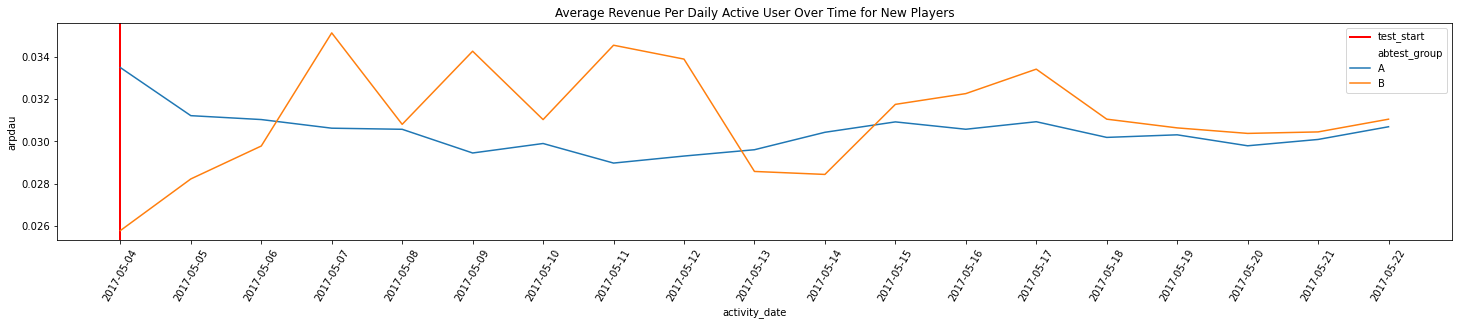

In [221]:
sql = """
with joined as (
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when assignment_date=install_date then 1 else 0 end as new_player_flag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)>=cast(assignment_date as date)
),
historical as
(
select a.*, abtest_group, assignment_date, install_date, conversion_date
,case when assignment_date=install_date then 1 else 0 end as new_player_flag
from abtest.activity a
inner join abtest.assignment b
on a.playerid=b.playerid
where cast(activity_date as date)<cast(assignment_date as date)
)
(select  abtest_group,activity_date, avg(purchases) as arpdau,new_player_flag,avg(gameends) as avg_gameends_per_player_per_day
from joined group by abtest_group,new_player_flag,activity_date)
union all
(select  abtest_group,activity_date, avg(purchases) as arpdau,new_player_flag,avg(gameends) as avg_gameends_per_player_per_day
from historical group by abtest_group,activity_date,new_player_flag)
"""
df =query_bq(sql)
df_A=df.loc[df.abtest_group=='A']
fig, ax = plt.subplots()
fig.set_size_inches(25, 4)
plt.xticks(rotation=60)
ax.axvline(x=0 , color='red', linewidth=2, label='test_start')
ax = sns.lineplot(x="activity_date", y="arpdau", hue="abtest_group", data=df.loc[df.new_player_flag==1])
ax.set_title('Average Revenue Per Daily Active User Over Time for New Players')

Text(0.5, 1.0, 'Average Revenue Per Daily Active User Over Time For Old Players')

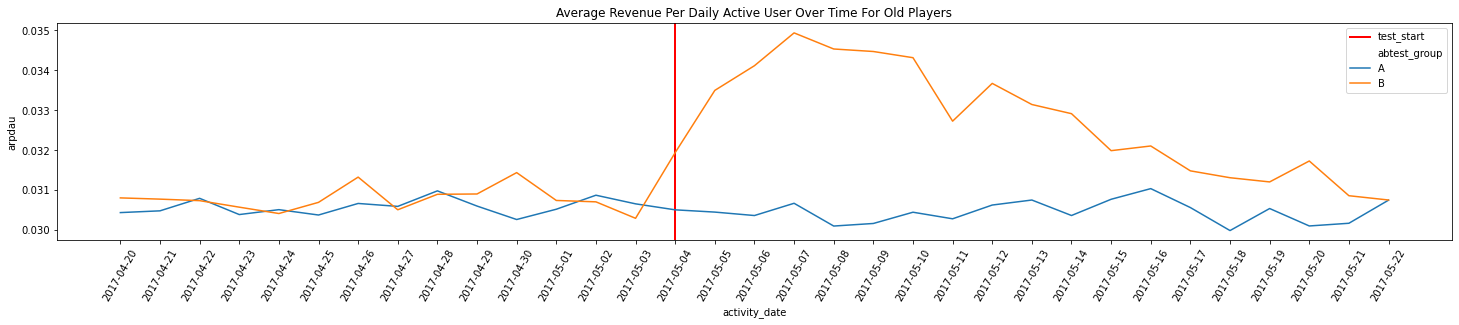

In [222]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4)
plt.xticks(rotation=60)
ax.axvline(x=14 , color='red', linewidth=2, label='test_start')
ax = sns.lineplot(x="activity_date", y="arpdau", hue="abtest_group", data=df.loc[df.new_player_flag==0])
ax.set_title('Average Revenue Per Daily Active User Over Time For Old Players')

## 5 Recommendation and Conclusion

The AB test for Math Puzzle Game was run successfully according to design specifications.

From our anlysis of the metrics we can conclude the following:
* The treatment did not show any statistically significant change in conversion.
* The treatment did not show any statistically significant change in retention.
* The treatment has a negative effect on engagement by decreasing the average game rounds played per player. 
* The treatment increased the average revenue per daily active user, but this seems to be due to a novely effect, and infact fades over time. Both new players and old players has less engagement towards the treatment. While, old players are more likely to have a spend than new players under the treatment.

Due to a decrease in engagement and since the increase in Average Revenue per daily active user is caused due to a novelty effect, and finally no significant change in conversions is observed under the treatment, we can conclude that the we should not implement the treatment, as the treatment has negative impact on the user experience based on the metrics.

The introduced treatment is most likely:
* An increase in difficulty of the levels, due to which number of gamerounds that a player could play reduced, hence decreasing the engagement. The old paying players ended up purchasing hints due to a combination of novelty and due to the increased difficulty of the level. 

**Reccomendation**
In this AB Test, we observed an interesting phenomena where the old players actaully ended up spending more due to the introduction of a new feature. We can infer from this observation that by periodically releasing new experiences that do not negatively impact engagement, we can increase in-game revenue.


In [227]:
##Shabeel Kandi